In [17]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

print("All required libraries imported successfully!")

All required libraries imported successfully!


In [3]:
# Cell 2: Load datasets
fraud_data = pd.read_csv(r'C:/Users/Daniel.Temesgen/Desktop/KIAM/week89/Fraud_Data.csv')
ip_data = pd.read_csv(r'C:/Users/Daniel.Temesgen/Desktop/KIAM/week89/IpAddress_to_Country.csv')
creditcard_data = pd.read_csv(r'C:/Users/Daniel.Temesgen/Desktop/KIAM/creditcard.csv')

print("Datasets loaded successfully!")
print(f"Fraud Data shape: {fraud_data.shape}")
print(f"Credit Card Data shape: {creditcard_data.shape}")
print(f"IP Data shape: {ip_data.shape}")

Datasets loaded successfully!
Fraud Data shape: (151112, 11)
Credit Card Data shape: (284807, 31)
IP Data shape: (138846, 3)


In [4]:
# Cell 3: Handle missing values
def handle_missing_values(df, dataset_name):
    print(f"\nMissing values in {dataset_name}:")
    print(df.isnull().sum())
    
    # For fraud_data, drop rows with missing critical fields
    if dataset_name == 'Fraud_Data':
        df = df.dropna(subset=['user_id', 'purchase_time', 'purchase_value'])
        # Impute missing categorical with mode
        for col in ['source', 'browser', 'sex']:
            if col in df.columns:
                df[col] = df[col].fillna(df[col].mode()[0])
        # Impute missing age with median
        df['age'] = df['age'].fillna(df['age'].median())
    elif dataset_name == 'creditcard':
        # For creditcard, drop rows with missing Amount or Class
        df = df.dropna(subset=['Amount', 'Class'])
    
    return df

fraud_data = handle_missing_values(fraud_data, 'Fraud_Data')
creditcard_data = handle_missing_values(creditcard_data, 'creditcard')

print("\nMissing values handled successfully!")


Missing values in Fraud_Data:
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

Missing values in creditcard:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Missing values handled successfully!


In [5]:
# Cell 4: Data cleaning
# Remove duplicates
fraud_data = fraud_data.drop_duplicates()
creditcard_data = creditcard_data.drop_duplicates()

# Correct data types
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])
fraud_data['user_id'] = fraud_data['user_id'].astype(int)
fraud_data['purchase_value'] = fraud_data['purchase_value'].astype(float)
fraud_data['age'] = fraud_data['age'].astype(int)

print("Data cleaning completed successfully!")

Data cleaning completed successfully!


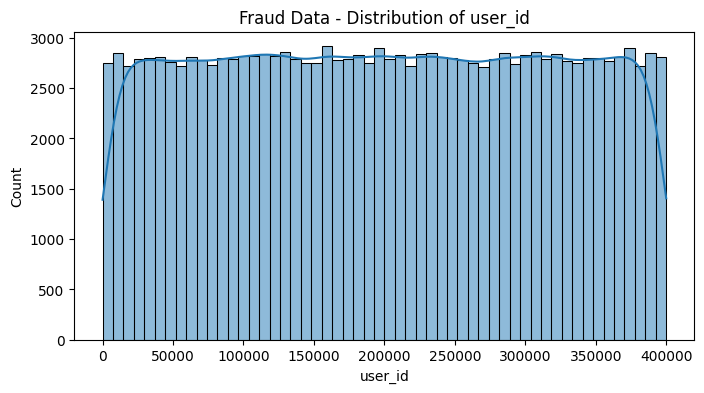

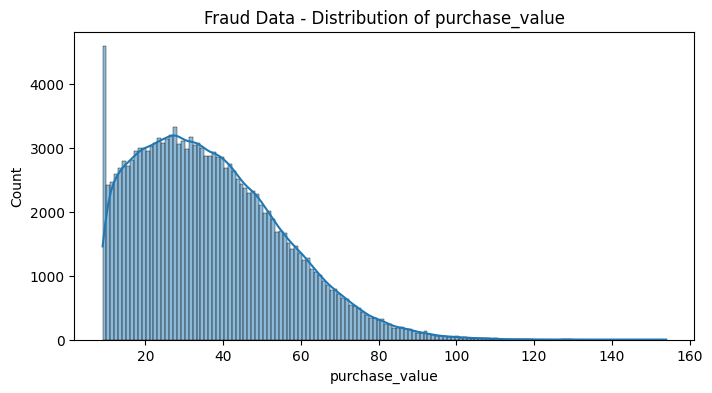

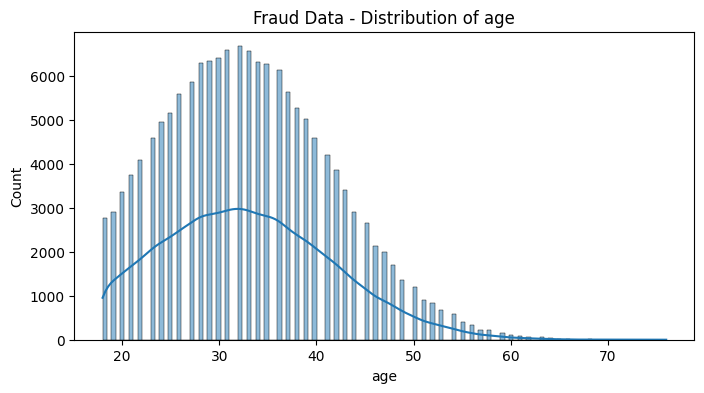

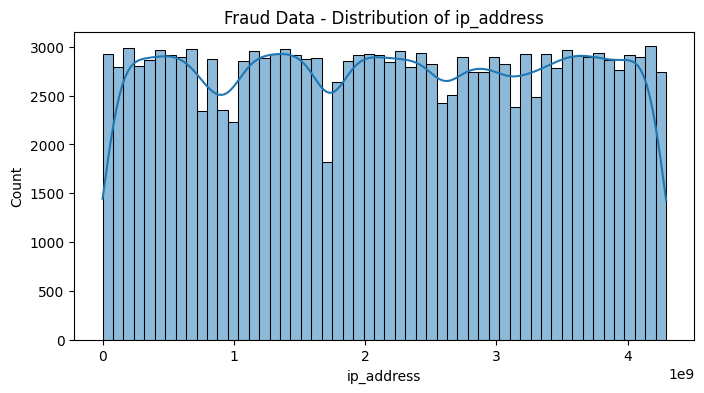

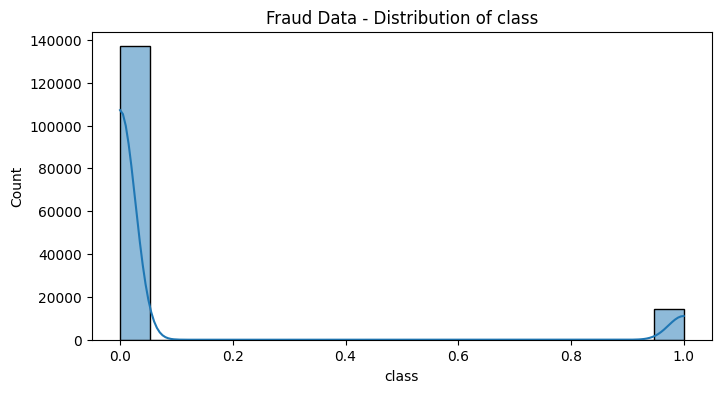

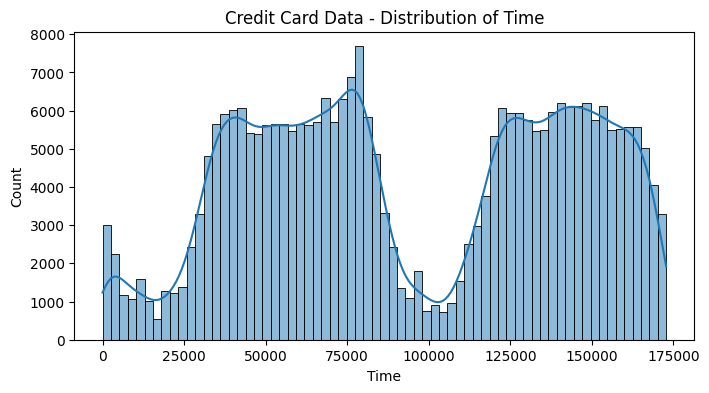

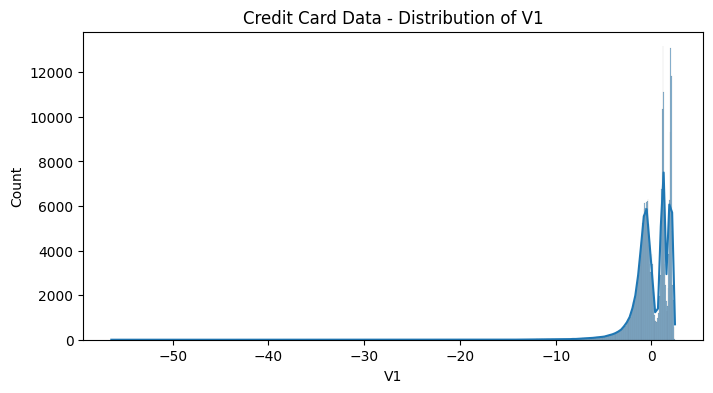

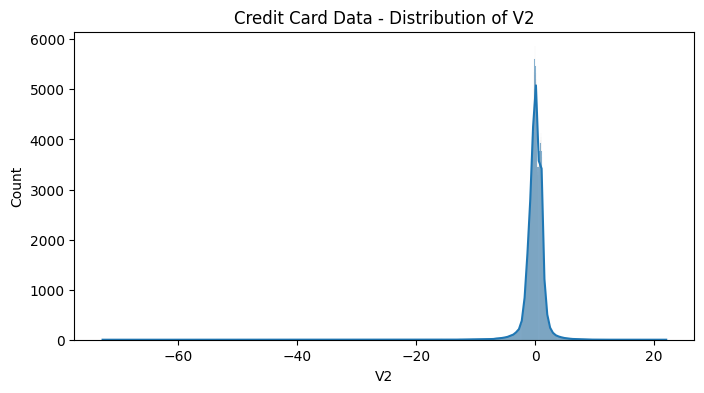

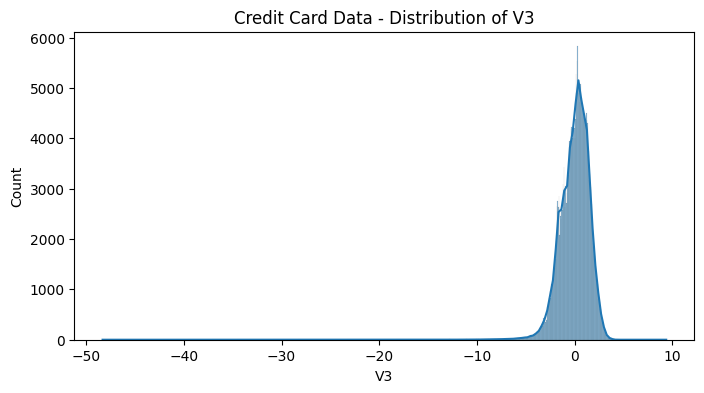

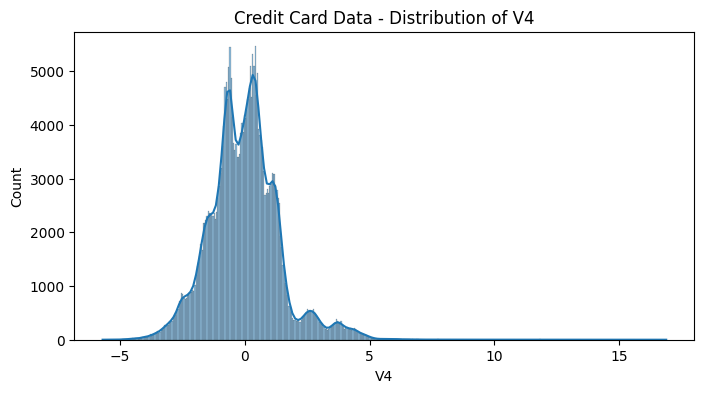

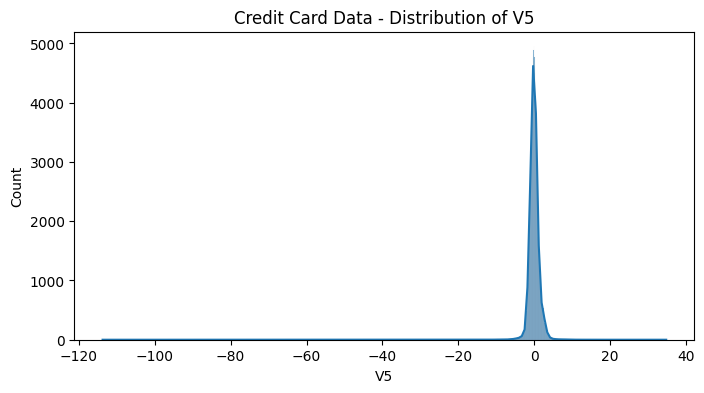

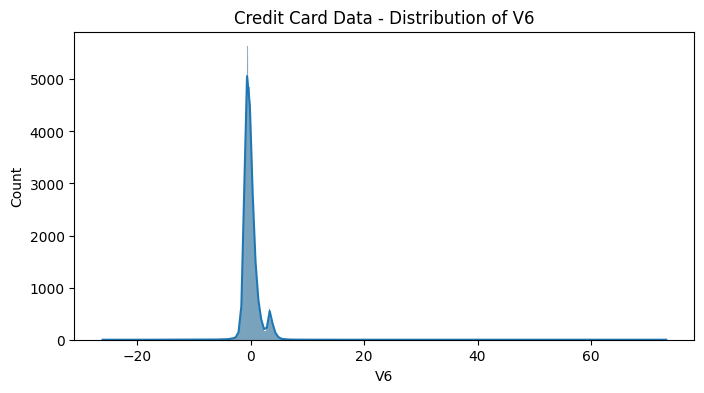

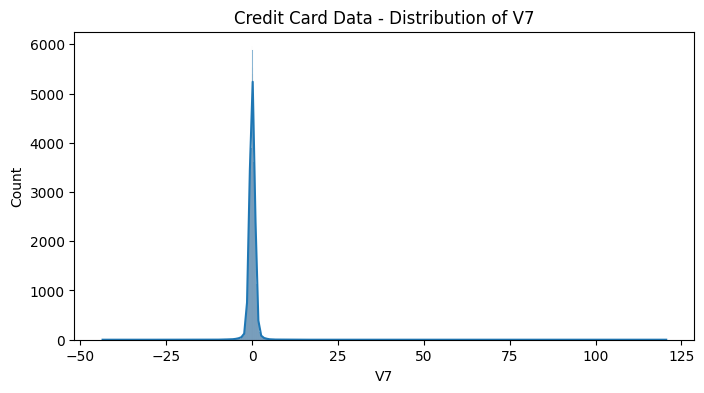

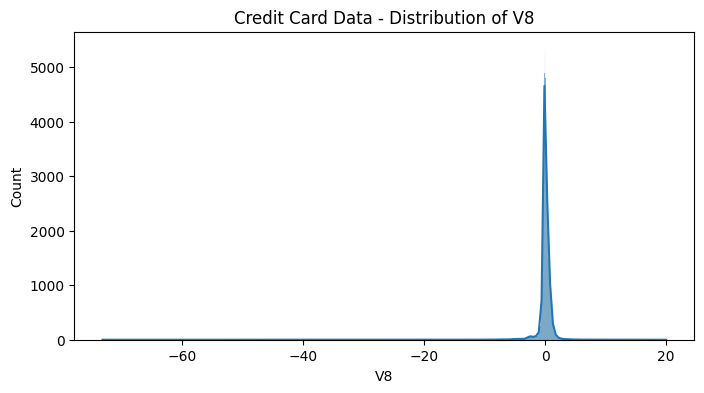

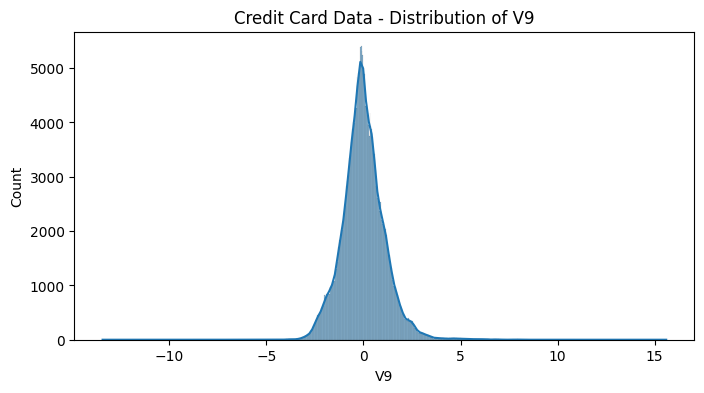

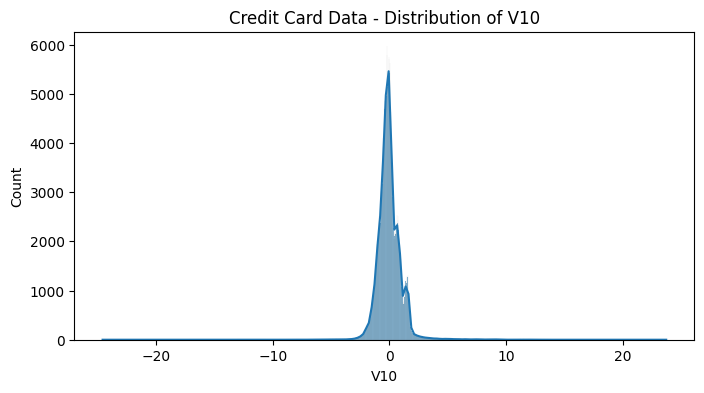

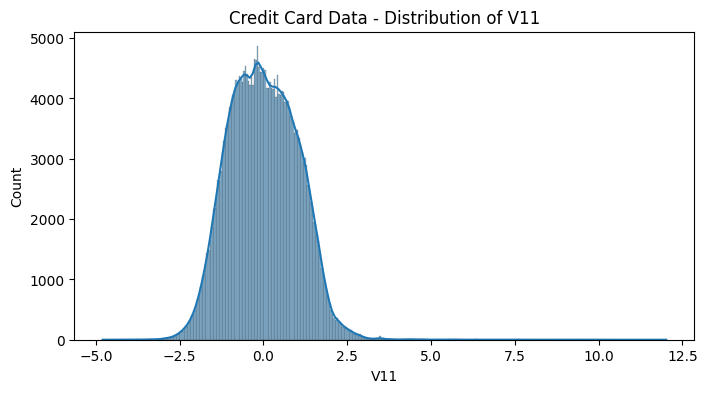

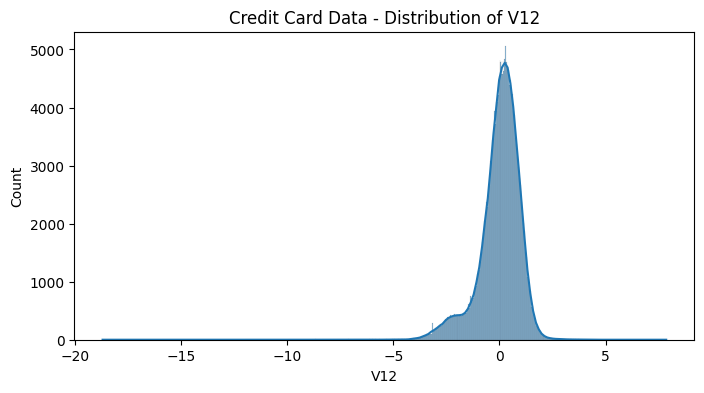

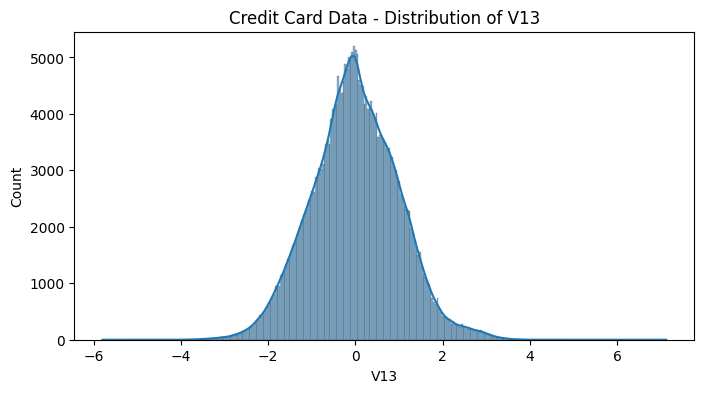

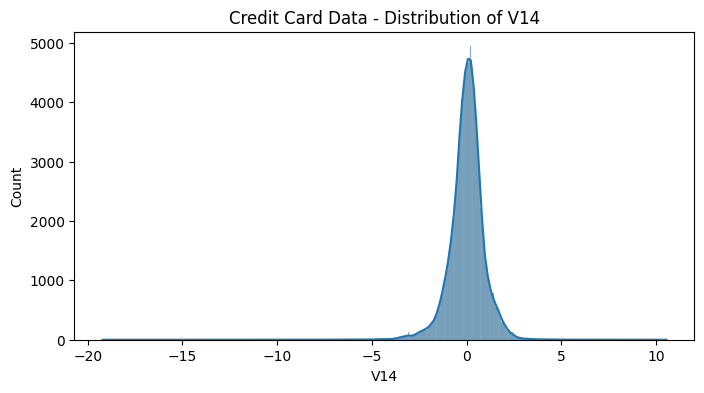

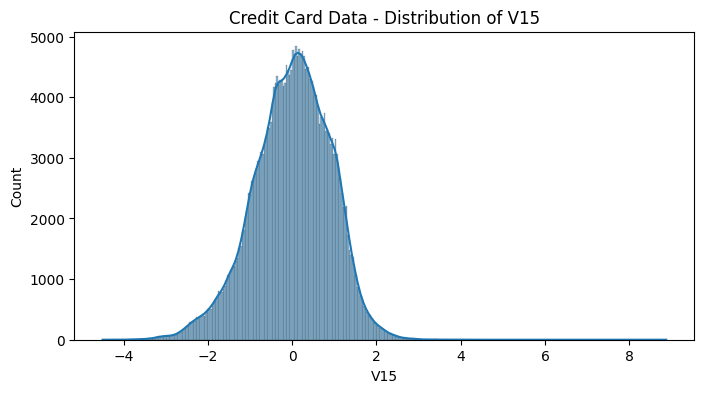

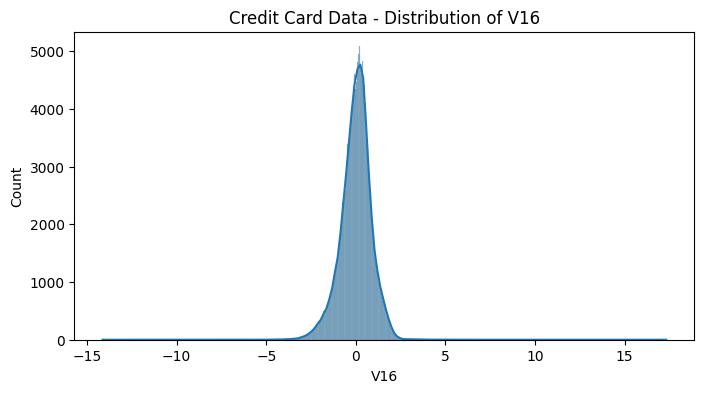

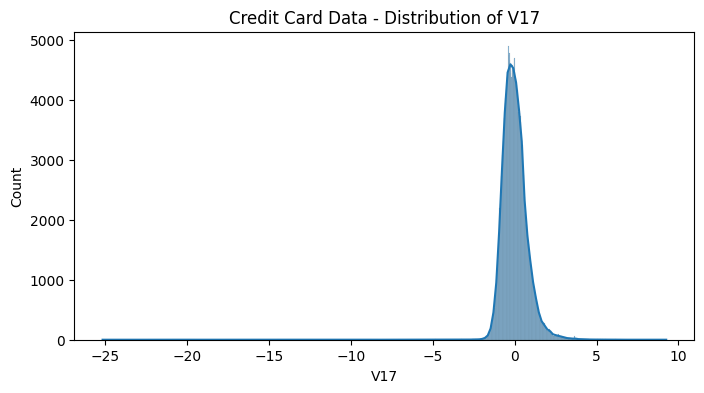

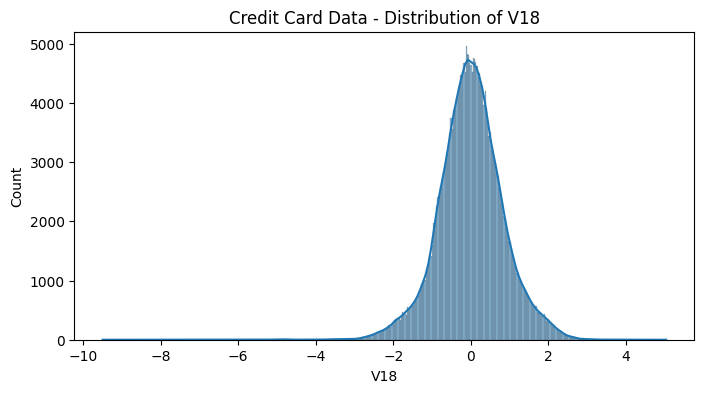

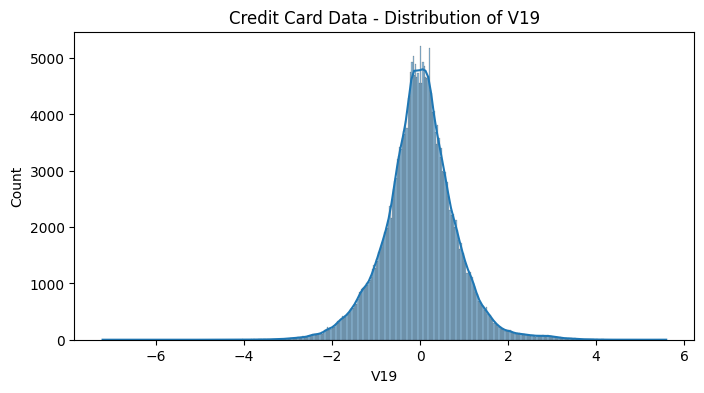

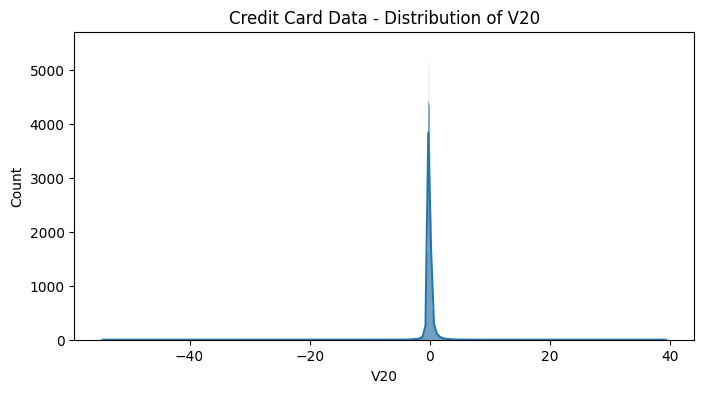

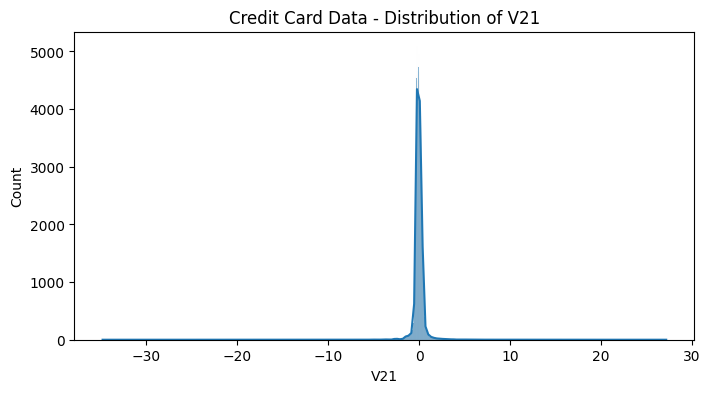

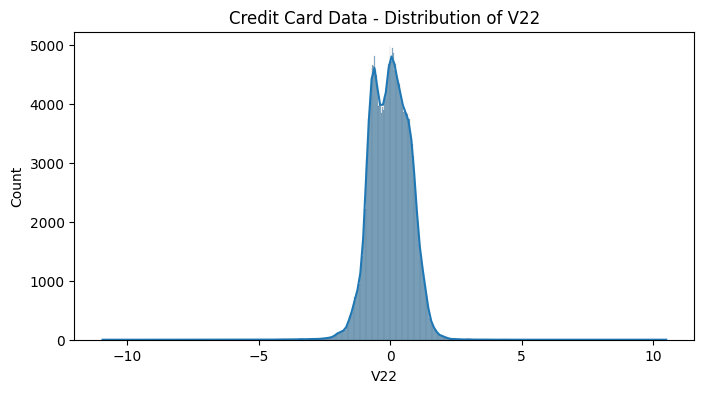

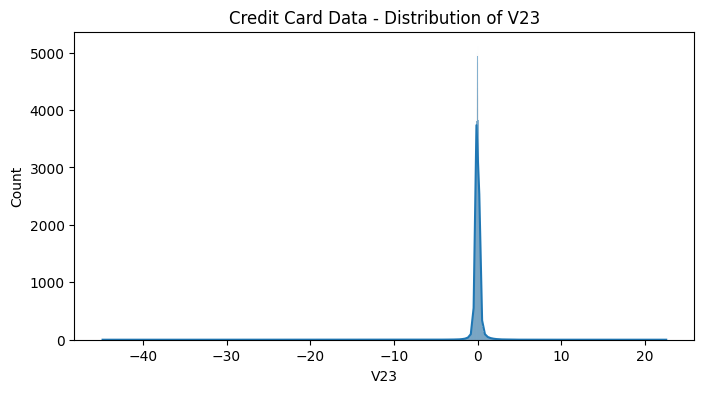

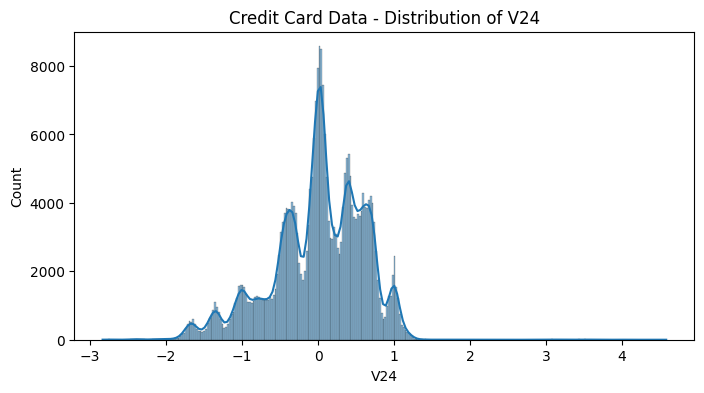

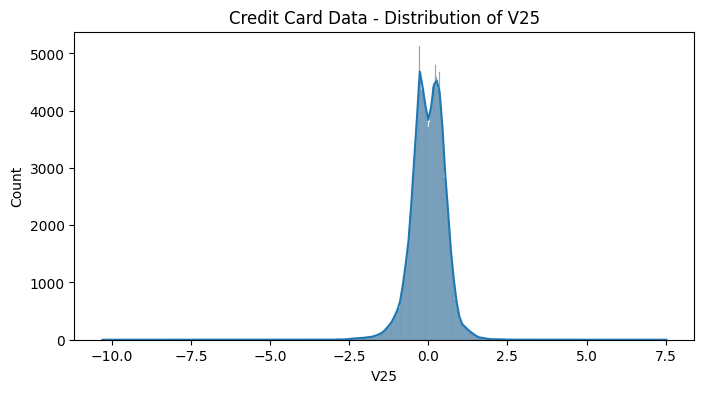

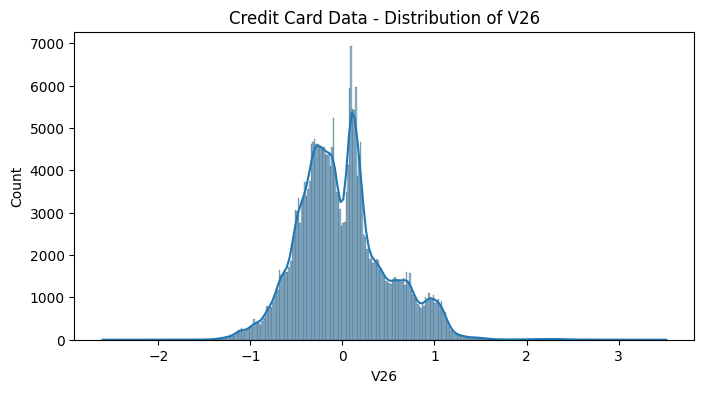

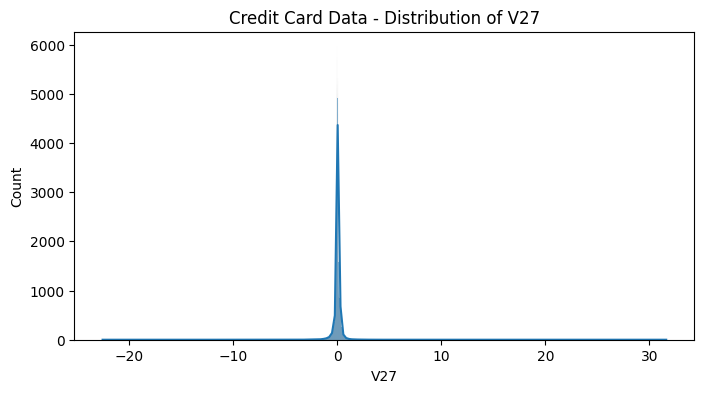

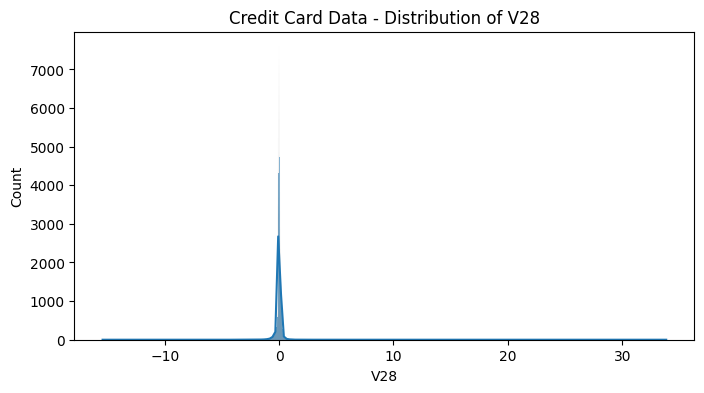

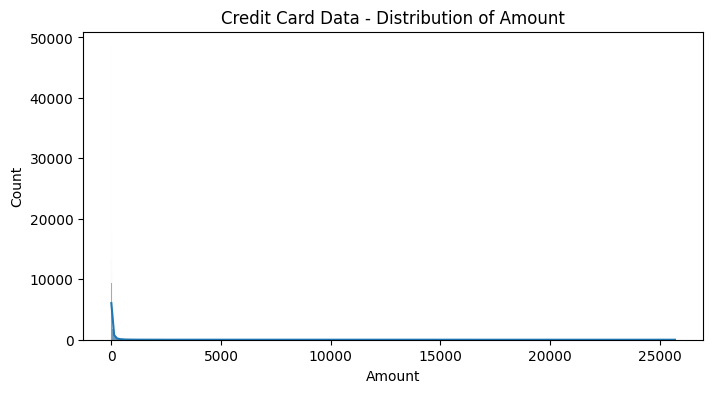

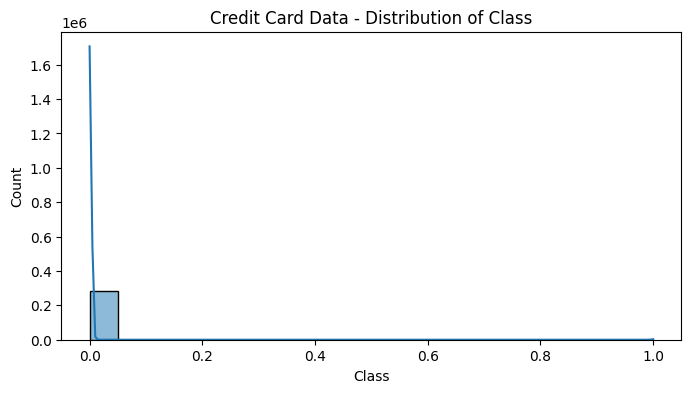

In [6]:
# Cell 5: EDA - Numerical columns
def plot_numerical_eda(df, dataset_name):
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col], kde=True)
        plt.title(f'{dataset_name} - Distribution of {col}')
        plt.show()

plot_numerical_eda(fraud_data, 'Fraud Data')
plot_numerical_eda(creditcard_data, 'Credit Card Data')

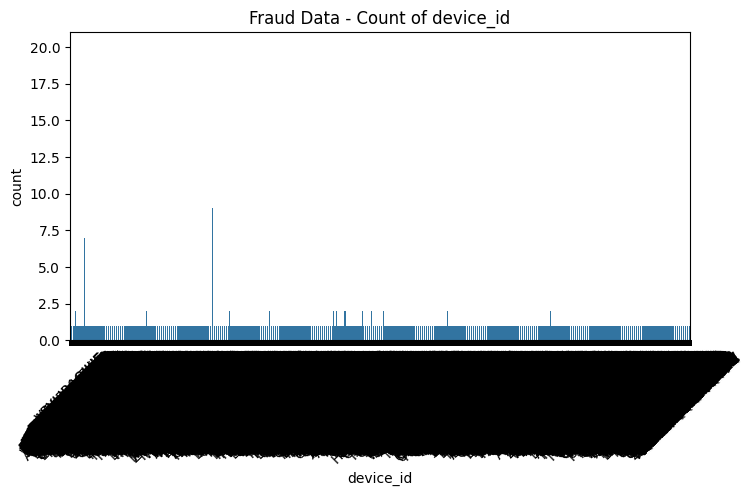

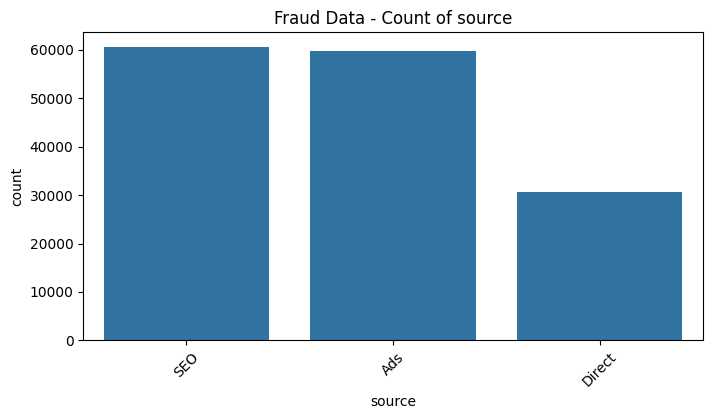

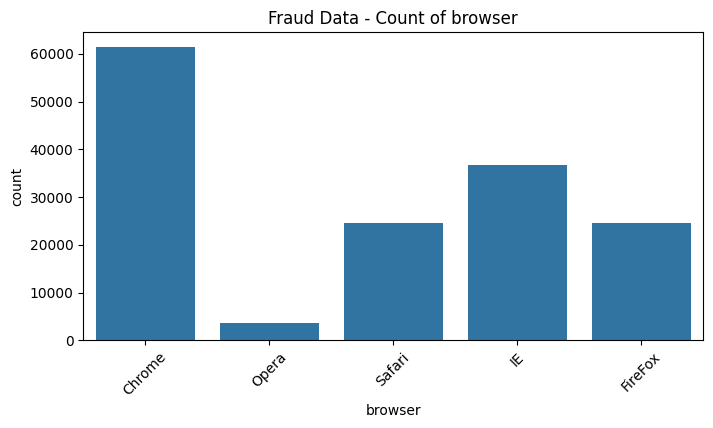

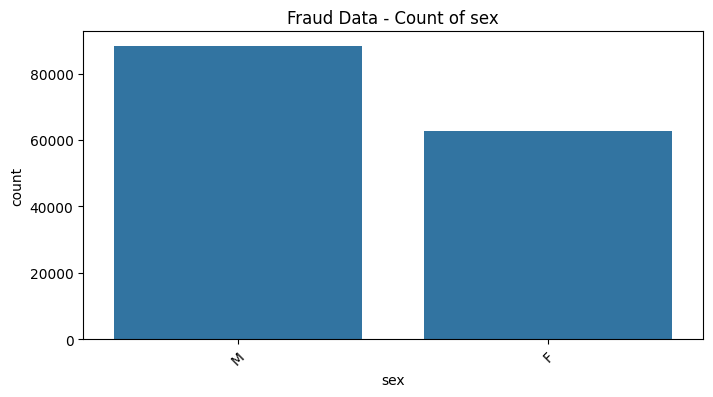

In [7]:
# Cell 6: EDA - Categorical columns
def plot_categorical_eda(df, dataset_name):
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        plt.figure(figsize=(8, 4))
        sns.countplot(data=df, x=col)
        plt.title(f'{dataset_name} - Count of {col}')
        plt.xticks(rotation=45)
        plt.show()

plot_categorical_eda(fraud_data, 'Fraud Data')

In [11]:
# Cell 7: Merge datasets for geolocation analysis
def ip_to_int(ip):
    try:
        parts = ip.split('.')
        return sum(int(part) * (256 ** (3 - i)) for i, part in enumerate(parts))
    except:
        return np.nan

fraud_data['ip_int'] = fraud_data['ip_address'].apply(ip_to_int)

def map_ip_to_country(ip_int, ip_data):
    try:
        if np.isnan(ip_int):
            return 'Unknown'
        match = ip_data[(ip_data['lower_bound_ip_address'] <= ip_int) & 
                       (ip_data['upper_bound_ip_address'] >= ip_int)]
        return match['country'].iloc[0] if not match.empty else 'Unknown'
    except:
        return 'Unknown'

fraud_data['country'] = fraud_data['ip_int'].apply(lambda x: map_ip_to_country(x, ip_data))

print("Geolocation analysis completed!")
display(fraud_data[['ip_address', 'country']].head())

Geolocation analysis completed!


,ip_address,country
0,7.327584e+08,Unknown
1,3.503114e+08,Unknown
2,2.621474e+09,Unknown
3,3.840542e+09,Unknown
4,4.155831e+08,Unknown


In [12]:
# Cell 8: Feature engineering for Fraud_Data
# Transaction frequency and velocity
user_purchase_counts = fraud_data.groupby('user_id').size().reset_index(name='transaction_frequency')
fraud_data = fraud_data.merge(user_purchase_counts, on='user_id')

# Time-based features
fraud_data['hour_of_day'] = fraud_data['purchase_time'].dt.hour
fraud_data['day_of_week'] = fraud_data['purchase_time'].dt.dayofweek
fraud_data['time_since_signup'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds() / 3600

print("Feature engineering completed!")
display(fraud_data.head())

Feature engineering completed!


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,ip_int,country,transaction_frequency,hour_of_day,day_of_week,time_since_signup
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34.0,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,NaN,Unknown,1,2,5,1251.856111
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16.0,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,NaN,Unknown,1,1,0,4.984444
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15.0,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,NaN,Unknown,1,18,3,0.000278
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44.0,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,Unknown,1,13,0,136.690278
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39.0,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,NaN,Unknown,1,18,2,1211.516944


In [18]:
# Cell 9: Data transformation - Handle class imbalance
def handle_class_imbalance(X, y):
    print("\nClass distribution before SMOTE:")
    print(pd.Series(y).value_counts())
    
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    print("\nClass distribution after SMOTE:")
    print(pd.Series(y_resampled).value_counts())
    
    return X_resampled, y_resampled

# Prepare features for fraud_data
X_fraud = fraud_data.drop(['class', 'user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address', 'ip_int'], axis=1)
y_fraud = fraud_data['class']

# Encode categorical features
categorical_cols = ['source', 'browser', 'sex', 'country']
encoder = OneHotEncoder(handle_unknown='ignore')  # Removed sparse=False
X_encoded = pd.DataFrame(encoder.fit_transform(X_fraud[categorical_cols]).toarray())  # Added .toarray()
X_encoded.columns = encoder.get_feature_names_out(categorical_cols)
X_fraud = X_fraud.drop(categorical_cols, axis=1).reset_index(drop=True)
X_fraud = pd.concat([X_fraud, X_encoded], axis=1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_fraud, y_fraud, test_size=0.2, random_state=42)

# Apply SMOTE only to training data
X_train_resampled, y_train_resampled = handle_class_imbalance(X_train, y_train)

# Normalization and Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Save processed data
processed_data = pd.DataFrame(X_train_scaled, columns=X_train.columns)
processed_data['class'] = y_train_resampled
processed_data.to_csv('processed_fraud_data_train.csv', index=False)

test_data = pd.DataFrame(X_test_scaled, columns=X_test.columns)
test_data['class'] = y_test.reset_index(drop=True)
test_data.to_csv('processed_fraud_data_test.csv', index=False)

print("\nPreprocessing complete. Processed data saved as 'processed_fraud_data_train.csv' and 'processed_fraud_data_test.csv'")


Class distribution before SMOTE:
class
0    109588
1     11301
Name: count, dtype: int64

Class distribution after SMOTE:
class
0    109588
1    109588
Name: count, dtype: int64

Preprocessing complete. Processed data saved as 'processed_fraud_data_train.csv' and 'processed_fraud_data_test.csv'
